# **Diabetes Prediction**



In [18]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the dataset
df = pd.read_csv('F:\Project\Diabetes Classification\kaggle_diabetes.csv')

## **Exploring the dataset**

In [4]:
df.shape

(2000, 9)

In [5]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [6]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [9]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


In [10]:
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

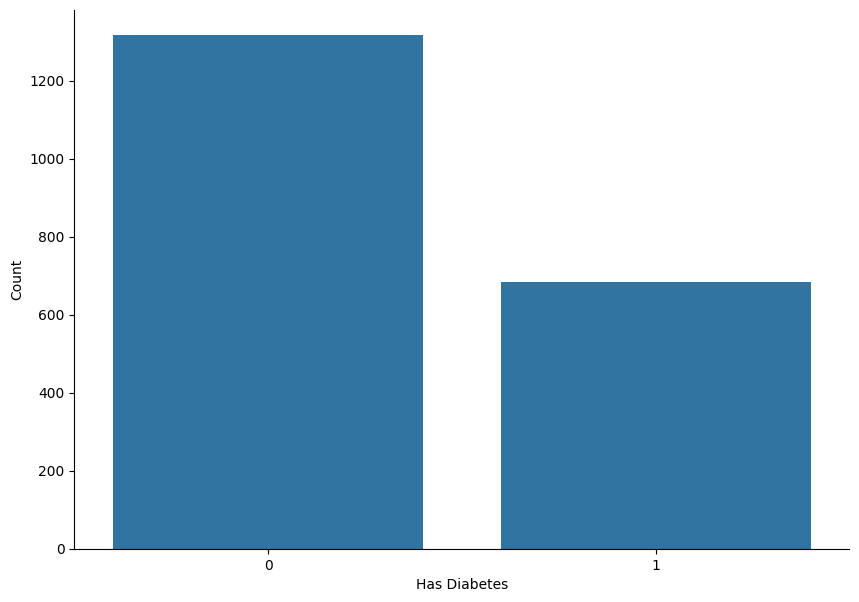

In [ ]:
# Plotting the Outcomes based on the number of dataset entries
plt.figure(figsize=(10,7))
sns.countplot(x='Outcome', data=df)

# Removing the unwanted spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Headings
plt.xlabel('Has Diabetes')
plt.ylabel('Count')

plt.show()

## **Data Cleaning**

In [11]:
df_copy = df.copy(deep=True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df_copy.isnull().sum()

Pregnancies                   0
Glucose                      13
BloodPressure                90
SkinThickness               573
Insulin                     956
BMI                          28
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

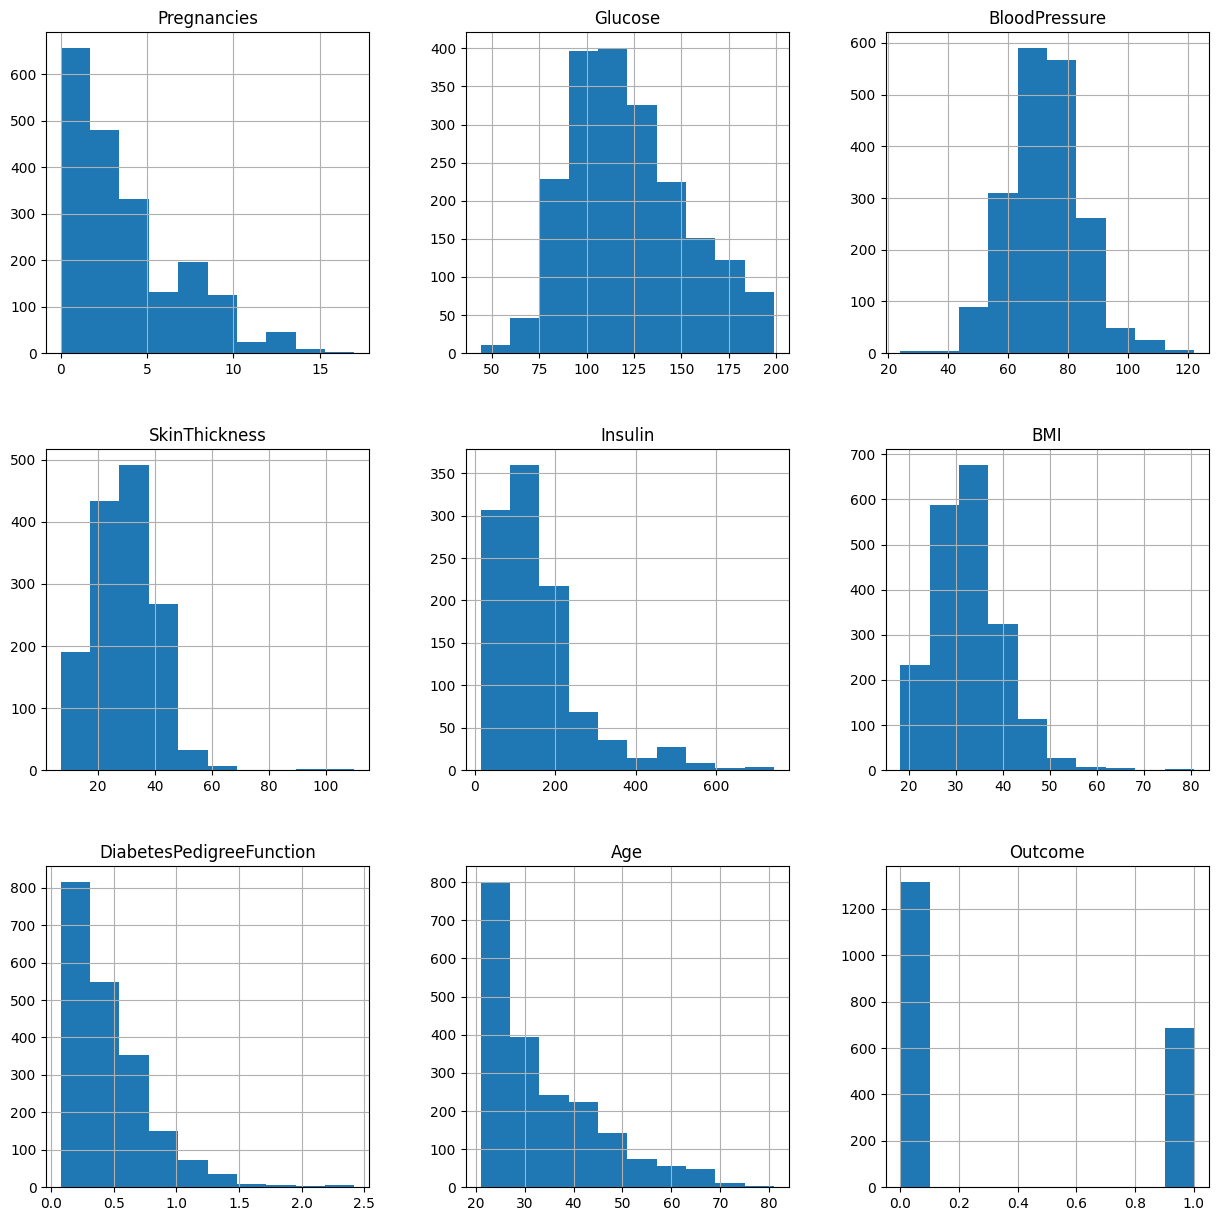

In [ ]:
# Plotting histogram of dataset before replacing NaN values
p = df_copy.hist(figsize = (15,15))

In [12]:
df_copy['Glucose'].fillna(df_copy['Glucose'].mean(), inplace=True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean(), inplace=True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median(), inplace=True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace=True)
df_copy['BMI'].fillna(df_copy['BMI'].median(), inplace=True)

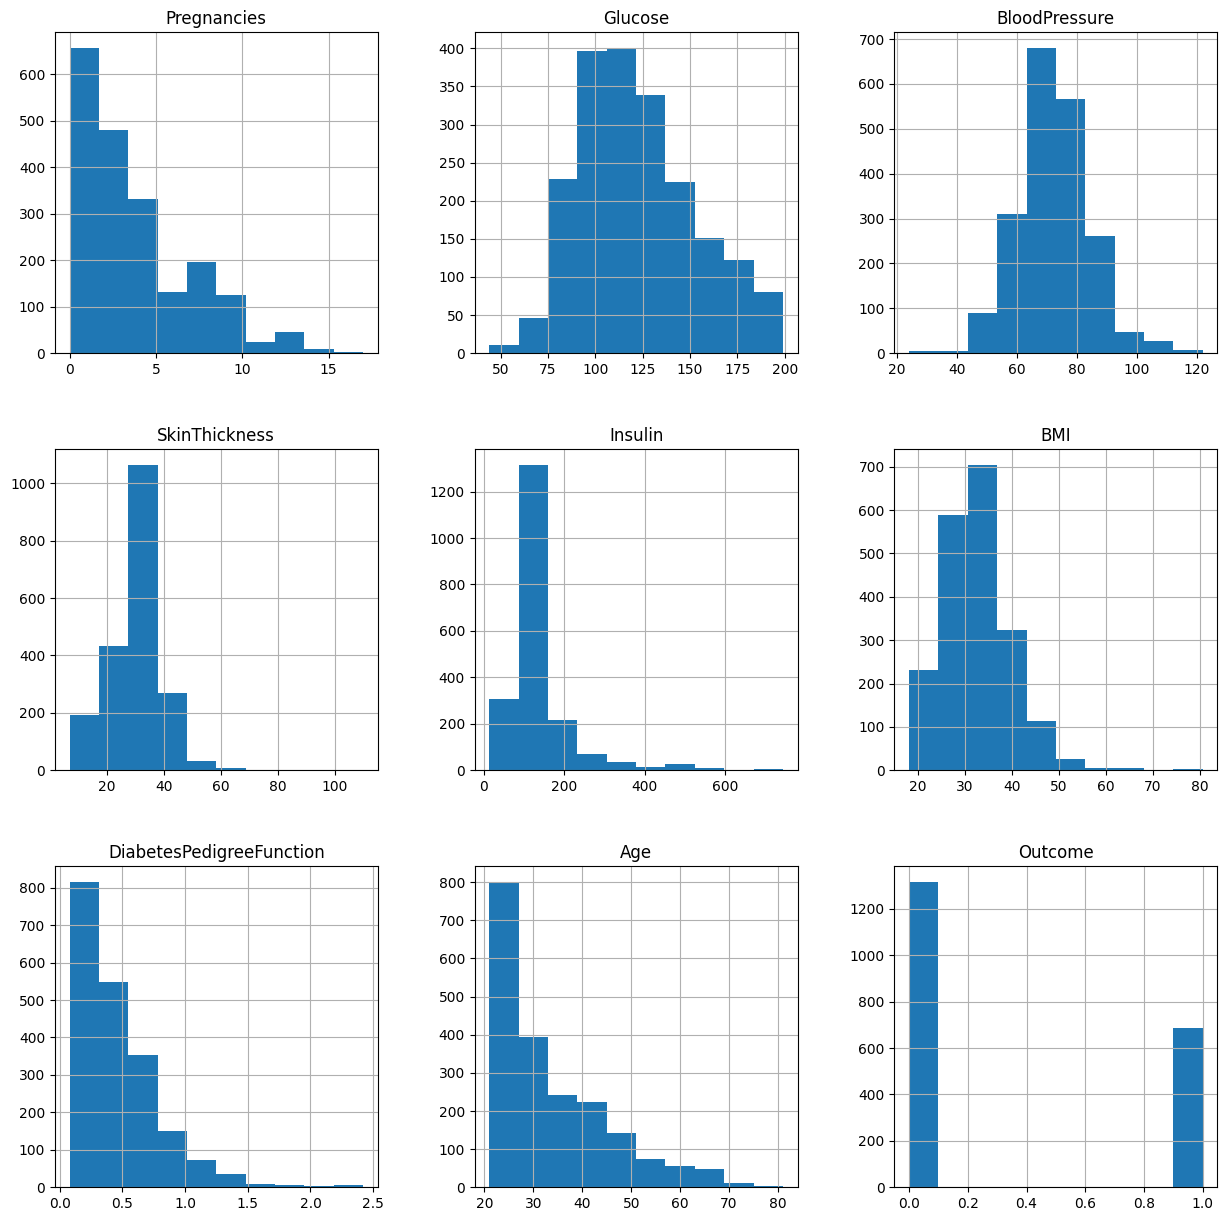

In [13]:
p = df_copy.hist(figsize=(15,15))

In [14]:
df_copy.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## **Model Building**

In [15]:
X = df.drop(columns='Outcome')
y = df['Outcome']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# Creating a function to calculate best model for this problem
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
            'parameters': {
                'C': [1,5,10],
                'penalty': ['l2'],
                'solver': ['lbfgs', 'saga']
               }
        },

        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None,5,10],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },

        'random_forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {
                'n_estimators': [10,20,50,100],
                'max_depth': [None, 5, 10],
                'min_samples_split': [2, 5, 10],
                'max_features': ['sqrt', 'log2']
            }
        },

        'svm': {
            'model': SVC(gamma='auto'),
            'parameters': {
                'C': [0.1,1,10,20],
                'kernel': ['rbf','linear'],
                'degree': [3, 5]
            }
        }

    }

    scores = []
    cv_kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_kfold, return_train_score=False,verbose=1)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })

    return pd.DataFrame(scores, columns=['model','best_parameters','score'])

find_best_model(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


,model,best_parameters,score
0,logistic_regression,"{'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}",0.775625
1,decision_tree,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.936250
2,random_forest,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.950000
3,svm,"{'C': 20, 'degree': 3, 'kernel': 'rbf'}",0.862500


*Note: Since the score of Decision Tree and Random forest are close but,
 Random Forest algorithm has the highest accuracy, we futher fine tune the model using hyperparameter optimization.*

In [20]:
scores = cross_val_score(RandomForestClassifier(random_state=0), X_train, y_train, cv=5)
print('Average Accuracy : {}%'.format(round(sum(scores)*100/len(scores)), 3))

Average Accuracy : 95%


In [21]:
# Creating Random Forest Model
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## **Model Evaluation**

In [22]:
y_train_pred = classifier.predict(X_train)
cmatrix = confusion_matrix(y_train, y_train_pred)
cmatrix

array([[1044,    0],
       [   0,  556]], dtype=int64)

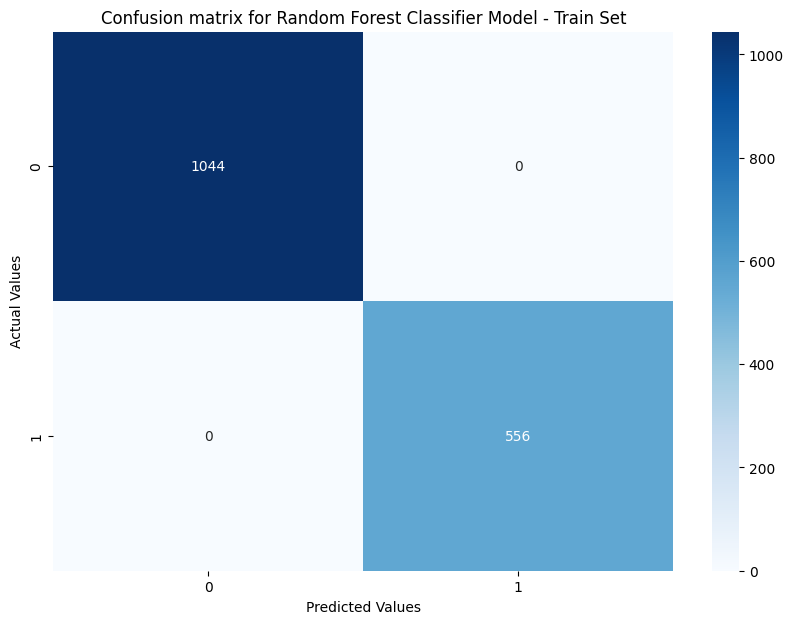

In [23]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cmatrix, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Train Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [24]:
score = round(accuracy_score(y_train, y_train_pred),4)*100
print("Accuracy on trainning set: {}%".format(score))

Accuracy on trainning set: 100.0%


In [25]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       1.00      1.00      1.00       556

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



In [26]:
y_pred = classifier.predict(X_test)
cmatrix = confusion_matrix(y_test, y_pred)
cmatrix

array([[272,   0],
       [  2, 126]], dtype=int64)

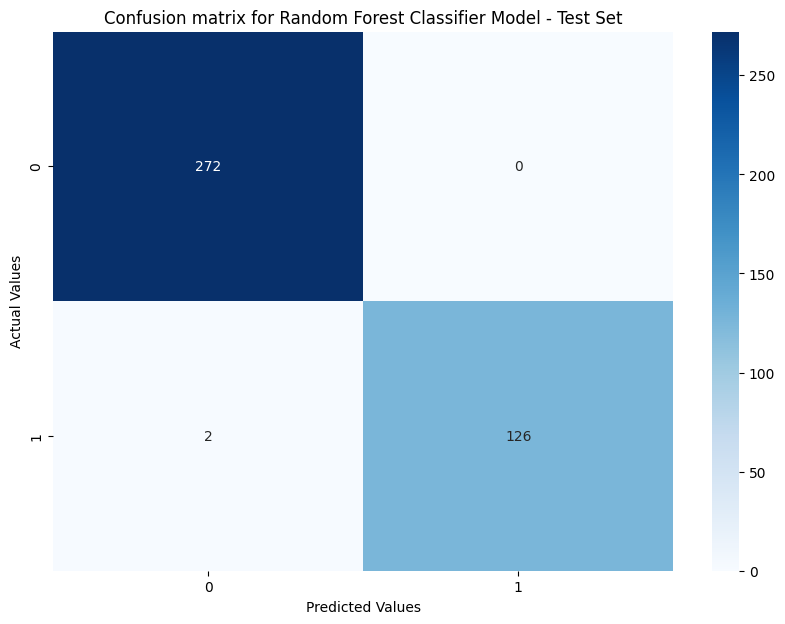

In [27]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cmatrix, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [28]:
score = round(accuracy_score(y_test, y_pred),4)*100
print("Accuracy on test set: {}%".format(score))

Accuracy on test set: 99.5%


In [29]:
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       272
           1       1.00      0.98      0.99       128

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400

ROC AUC Score: 0.9922


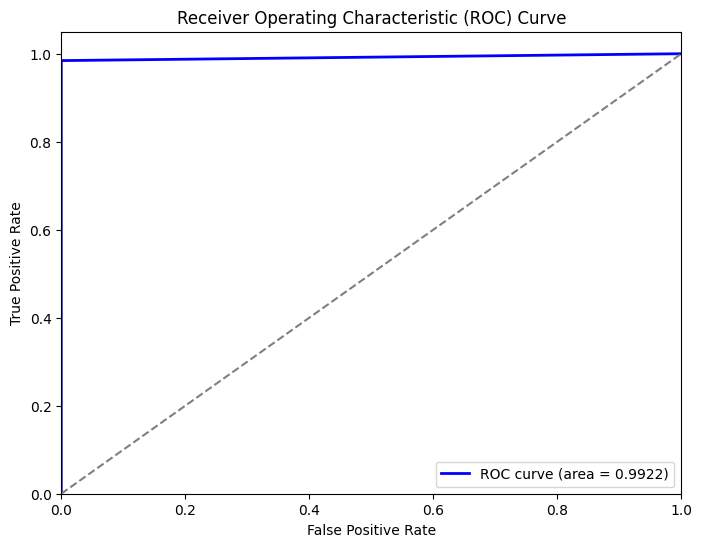

In [30]:
# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **Predictions**

In [31]:
# Creating a function for prediction
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age):
    preg = int(Pregnancies)
    glucose = float(Glucose)
    bp = float(BloodPressure)
    st = float(SkinThickness)
    insulin = float(Insulin)
    bmi = float(BMI)
    dpf = float(DiabetesPedigreeFunction)
    age = int(Age)

    x = [[preg, glucose, bp, st, insulin, bmi, dpf, age]]
    x = scaler.transform(x)

    return classifier.predict(x)

In [33]:
# Prediction 1
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(2, 81, 72, 15, 76, 30.1, 0.547, 25)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.


In [34]:
# Prediction 2
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(1, 117, 88, 24, 145, 34.5, 0.403, 40)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Oops! You have diabetes.


In [35]:
# Prediction 3
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(5, 120, 92, 10, 81, 26.1, 0.551, 67)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.
